In [60]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch

from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn

from tensorflow import keras
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision import models
from tqdm import tqdm, trange
# from tqdm.notebook import trange


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# fashion_mnist=keras.datasets.fashion_mnist
# (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [23]:
# print("X_train shape:" + str(X_train.shape))
# print("y_train shape:" + str(y_train.shape))
# print("X_test shape:" + str(X_test.shape))
# print("y_test shape:" + str(y_test.shape))

In [24]:
# # Convert to float and normalize
# X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) / 255.0
# X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1) / 255.0

# # Convert labels
# y_train = torch.tensor(y_train, dtype=torch.long)
# y_test = torch.tensor(y_test, dtype=torch.long)

# print(X_train.shape)  # (60000, 1, 28, 28)
# print(y_train.shape)  # (60000,)

In [ ]:
# dataset_train = TensorDataset(X_train, y_train)
# dataset_test = TensorDataset(X_test, y_test)

In [25]:
IMAGE_SIZE = 16

transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
transforms.ToTensor()#
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [28]:
dataset_train=dsets.FashionMNIST(root= '.fashion/data', train=True, transform=composed,  download=True)
dataset_test = dsets.FashionMNIST(root= '.fashion/data', train=False, transform=composed,  download=True) 

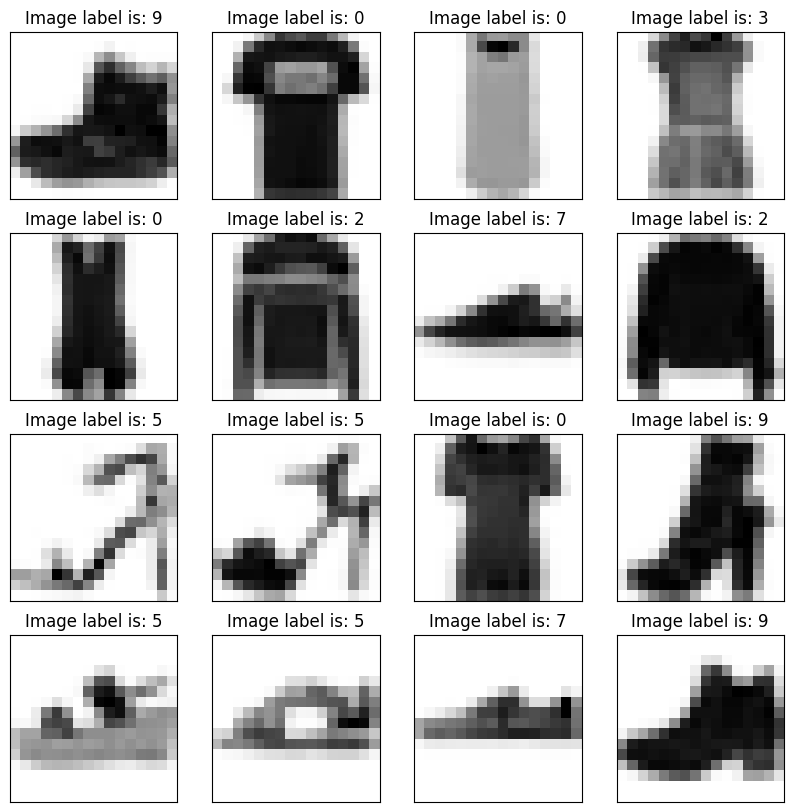

In [29]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset_train[i][0].squeeze(), cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(dataset_train[i][1]))
plt.show()

In [37]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [38]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [ ]:
train_loader = DataLoader(dataset=dataset_train, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=100)

In [40]:
#model = CNN(out_1=16, out_2=32,number_of_classes=10)
model =CNN_batch(out_1=16, out_2=32,number_of_classes=10)

In [41]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [50]:
%%time

cost_list=[]
accuracy_list=[]
N_train=len(dataset_train)
N_test=len(dataset_test)
n_epochs=5
for epoch in tqdm(range(n_epochs)):
    cost=0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost+=loss.item()*x.size(0)
    correct=0
    #perform a prediction on the validation  data 
    model.eval()
    with torch.no_grad():
        for x_test, y_test in test_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost = cost / N_train
    cost_list.append(cost)
    

100%|██████████| 5/5 [01:56<00:00, 23.28s/it]

CPU times: total: 7min 24s
Wall time: 1min 56s


In [52]:
from torchsummary import summary
summary(model, input_size=(1, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
       BatchNorm2d-2           [-1, 16, 16, 16]              32
         MaxPool2d-3             [-1, 16, 8, 8]               0
            Conv2d-4             [-1, 32, 8, 8]          12,832
       BatchNorm2d-5             [-1, 32, 8, 8]              64
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Linear-7                   [-1, 10]           5,130
       BatchNorm1d-8                   [-1, 10]              20
Total params: 18,494
Trainable params: 18,494
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.07
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


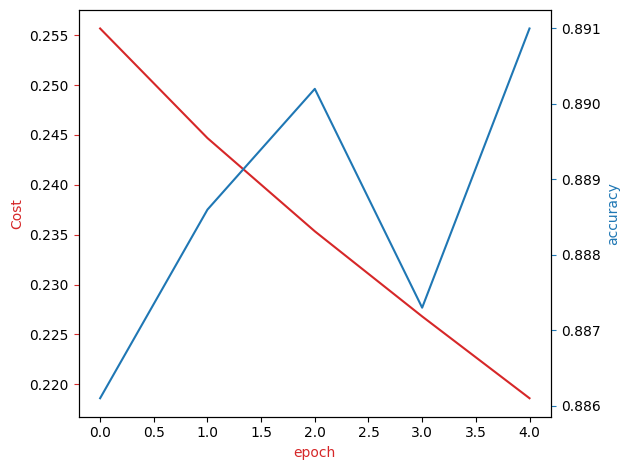

In [53]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [54]:
accuracy_list

[0.8861, 0.8886, 0.8902, 0.8873, 0.891]

# ResNet

In [56]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # MNIST is 1ch → convert to 3ch
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [57]:
dataset_train=dsets.FashionMNIST(root= '.fashion/data', train=True, transform=composed,  download=True)
dataset_test = dsets.FashionMNIST(root= '.fashion/data', train=False, transform=composed,  download=True) 

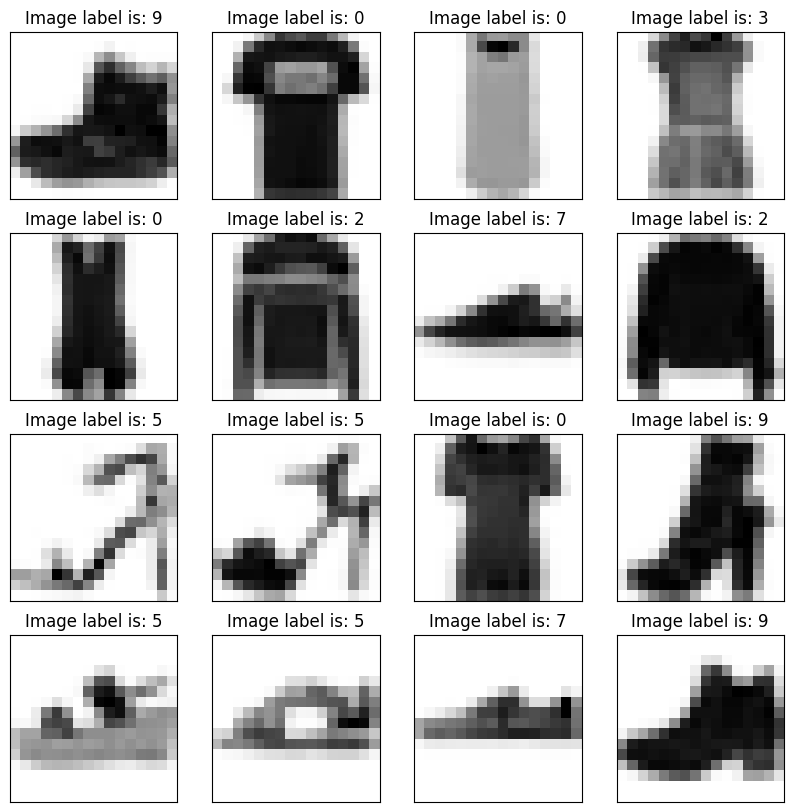

In [58]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset_train[i][0].squeeze(), cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(dataset_train[i][1]))
plt.show()

In [63]:
try:
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # newer torchvision
except Exception:
    resnet = models.resnet18(pretrained=True) 

resnet.fc = nn.Linear(resnet.fc.in_features, 10)

In [71]:
train_loader = DataLoader(dataset=dataset_train, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=100)

In [77]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(resnet.parameters(), lr = learning_rate)

In [83]:
%%time

cost_list=[]
accuracy_list=[]
N_train=len(dataset_train)
N_test=len(dataset_test)
n_epochs=5
for epoch in tqdm(range(n_epochs)):
    cost=0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost+=loss.item()
    correct=0
    #perform a prediction on the validation  data 
    model.eval()
    with torch.no_grad():
        for x_test, y_test in test_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    # cost = cost / N_train
    cost_list.append(cost)
    

100%|██████████| 5/5 [01:54<00:00, 22.93s/it]

CPU times: total: 7min 26s
Wall time: 1min 54s


In [84]:
from torchsummary import summary
summary(resnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

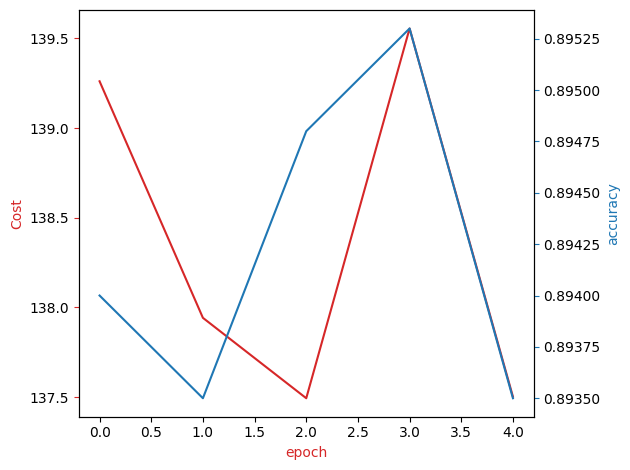

In [85]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [86]:
accuracy_list

[0.894, 0.8935, 0.8948, 0.8953, 0.8935]

In [82]:
cost_list

[0.2304172678415974,
 0.22972916449109712,
 0.2300740327934424,
 0.2307496748243769,
 0.23178001758952935]